In [53]:
import numpy as np
import scipy as scp

from matplotlib import pyplot as plt
%matplotlib inline

In [514]:
class Processor:
    
    
    def __init__(self):
        self.N = self.n_signal = 0
        self.alpha = 1
        self.Y = self.y0 = None
        
    def fit(self, Y_fit, y0_fit):
        if self.Y is not None or self.y0 is not None:
            throw("Error: fit already fitted Processor. Use add_fit().")
        self.Y = Y_fit.copy()
        self.y0 = y0_fit.copy()
        self.n_signal = Y_fit.shape[-1]
        self.N = y0_fit.size
        if (Y_fit.shape[0] != self.N):
            print("Error: not matching shapes for profit_item and, profit_case")
        
    def params_init(self):
        n = self.n_signal; N = self.N
        y0 = self.y0; Y = self.Y 
        self.P = np.zeros((n, n-1))
        self.P[np.arange(n-1), np.arange(n-1)] = 1
        self.P[n-1] = -1
        #self.P[-1, -1] = -1
        self.p = np.zeros((n, 1))
        self.p[n-1] = 1
        
        self.At = np.zeros((N, n, n))
        #print(n, (1+y0)[np.newaxis, :].shape, self.At[:,np.arange(n),np.arange(n)].shape)
        self.At[:,np.arange(n),np.arange(n)] = (1+Y)/(1+y0)[:, np.newaxis]
        #np.diagonal(self.A, axis1=1, axis2=2) = 
        
        self.U = np.diag(np.ones((n,))*self.alpha)
        
        
    def add_fit(self, Y_add, y0_add):
        if self.n_signal != Y_add.shape[-1]:
            throw("Error: not appropriate added signals length.")
        self.N += Y_add.shape[0]
        self.Y = np.concatenate((self.Y, Y_add))
        self.y0 = np.concatenate((self.y0, y0_add))
    
    def CalcRegr_prepare(self, equal_constraint=True):
        n = self.n_signal
        N = self.N
        # transform due to equality constraints
        Y = self.Y.copy()
        y0 = self.y0.copy()
        U = self.U.copy()
        At = self.At.copy()
        P = self.P
        p = self.p
        alpha = self.alpha
        
        if equal_constraint:
            y0 = y0 - self.Y[:, -1]
            Y = self.Y[:, :-1] - self.Y[:, -1].reshape(-1, 1)
            devider = np.sum(Y*Y, axis=1)
            devider[devider == 0] = 1
            self.a0 = a0 = (y0/devider)[:,np.newaxis]*Y
            a0[devider == 0, :] = 0
            self.Q0 = Q0 = Y[:, np.newaxis, :]*Y[:, :, np.newaxis]
            # not needed self.b0 = b0 = np.zeros((,)) # needed???
            Tmp = np.dot(At[1:,...].transpose(0,2,1), U)
            Tmp = np.sum(Tmp.transpose(0, 2, 1)[...,np.newaxis]*(np.eye(n)[np.newaxis,...] - At[1:,...])[...,np.newaxis,:], -3)
            #print(At[1:,...].transpose(0,2,1).shape, Tmp.shape)
            Tmp = (np.concatenate((np.zeros((1, n, n)), Tmp), axis=0) + 
                U.dot(At-np.eye(n)[np.newaxis,...]).transpose(1, 0, 2))
            a0 += (1/devider[:, np.newaxis])*np.dot(P.T, Tmp).transpose(1, 0, 2)[:, :, -1]
            
            Tmp = np.dot(P.T, U)
            At = np.transpose(np.dot((np.linalg.inv(Tmp.dot(P))).dot(Tmp), At), axes=(1, 0, 2)).dot(P)
            U = Tmp.dot(P)
        else:
            devider = np.sum(Y*Y, axis=1)
            devider[devider == 0] = 1
            self.a0 = a0 = (y0/devider)[:,np.newaxis]*Y
            a0[devider == 0, :] = 0
            self.Q0 = Q0 = Y[:, np.newaxis, :]*Y[:, :, np.newaxis]
            
        self.U = U
        self.At = At
        self.trans_Y = Y
        self.trans_y0 = y0
        return Y, y0, U, At
        
    def CalcRegression(equal_const=True):
        n = self.n_signal
        s_len = self.sig_len
        # transform due to equality constraints
        
    def ProcessTo(self):
        N = self.N; n = self.n_signal
        al = self.al = np.ones((N, n-1))
        Ql = self.Ql = np.empty((N, n-1, n-1))
        bl = self.bl = np.empty((N, n-1))
         
        a0 = self.a0
        Q0 = self.Q0
        
        al[0] = self.a0[0]
        bl[0] = np.zeros((n-1,))
        Ql[0] = self.Q0[0]
        
        U = self.U
        At = self.At
        
        for t in range(1, N):
            Tmp = U.dot(At[t]).dot(np.linalg.inv((At[t].T).dot(U).dot(At[t]) + Ql[t-1])).dot(
                Ql[t-1]).dot(np.linalg.inv(At[t]))
            Ql[t] = Q0[t] + Tmp
            al[t] = np.linalg.inv(Ql[t]).dot(Q0[t].dot(a0[t]) + Tmp.dot(At[t]).dot(al[t-1]))
            bl[t] =(bl[t-1]+np.dot((a0[t] - al[t]).T, Q0[t]).dot(a0[t]) + 
                np.dot((al[t-1]-((At[t]).T).dot(al[t])).T, Ql[t]-Q0[t]).dot(al[t-1]))
    
    def ProcessFrom(self):
        N = self.N; n = self.n_signal
        ar = self.ar = np.empty((N, n-1))
        Qr = self.Qr = np.empty((N, n-1, n-1))
        br = self.br = np.empty((N, n-1))

        a0 = self.a0
        Q0 = self.Q0

        ar[N-1] = self.a0[N-1]
        br[N-1] = np.zeros((n-1,))
        Qr[N-1] = self.Q0[N-1]

        U = self.U
        At = self.At
        
        for t in range(N-2, -1, -1):
            Tmp = (At[t+1].T).dot(U).dot(np.linalg.inv(U+Qr[t+1])).dot(Qr[t+1])
            Qr[t] = Q0[t] + Tmp.dot(At[t+1])
            ar[t] = np.linalg.inv(Qr[t]).dot(Q0[t].dot(a0[t]) + Tmp.dot(ar[t+1]))
            br[t] =(br[t+1]+np.dot((a0[t] - ar[t]).T, Q0[t]).dot(a0[t]) + 
                np.dot((ar[t+1]-((At[t+1]).T).dot(ar[t])).T, U).dot(
                    np.linalg.inv(U+Qr[t+1])).dot(Qr[t+1].dot(ar[t+1])))
    
    def Merge(self):
        ar = self.ar; al = self.al; a0 = self.a0
        Qr = self.Qr; Ql = self.Ql; Q0 = self.Q0
        br = self.br; bl = self.bl
        N = self.N; n = self.n_signal
        
        self.part_item = np.zeros((N, n-1))
        for t in range(N):
            if 0<t<N-1:
                Tmp1 = (At[t+1].T).dot(U).dot(np.linalg.inv(U+Qr[t+1])).dot(Qr[t+1])
                Tmp2 = U.dot(At[t]).dot(np.linalg.inv((At[t].T).dot(U).dot(At[t]) + Ql[t-1])).dot(
                        Ql[t-1])
                Q_t = Tmp1.dot(At[t+1]) + Q0[t]+Tmp2.dot(np.linalg.inv(At[t]))
                self.part_item[t] = np.linalg.inv(Q_t).dot(Tmp1.dot(ar[t+1])+Q0[t].dot(a0[t])+Tmp2.dot(al[t-1]))
            if not t:
                Tmp1 = (At[t+1].T).dot(U).dot(np.linalg.inv(U+Qr[t+1])).dot(Qr[t+1])
                self.part_item[t] = np.linalg.inv(Qr[t]+Q0[t]).dot(Tmp1.dot(ar[t+1])+Q0[t].dot(a0[t]))
            if t==N-1:
                Tmp2 = U.dot(At[t]).dot(np.linalg.inv((At[t].T).dot(U).dot(At[t]) + Ql[t-1])).dot(
                        Ql[t-1])
                self.part_item[t] = np.linalg.inv(Ql[t]+Q0[t]).dot(Tmp2.dot(al[t-1])+Q0[t].dot(a0[t]))
            

In [515]:
proc = Processor()
proc.fit(profit_item, profit_case)
proc.params_init()
Y, y0, U, At = proc.CalcRegr_prepare()
proc.ProcessTo()
proc.ProcessFrom()
proc.Merge()

In [516]:
proc.part_item

array([[ 1.72713514,  1.00503723],
       [ 1.66301954,  1.03838222],
       [ 1.60928418,  1.06580352],
       ..., 
       [ 2.26697185, -0.63433653],
       [ 2.08096612, -0.72503414],
       [ 1.36878859, -0.5457217 ]])

In [505]:
part_item

array([[ 0.29787577,  0.40424846,  0.29787577],
       [ 0.30211364,  0.39577272,  0.30211364],
       [ 0.30513973,  0.38972054,  0.30513973],
       ..., 
       [ 0.33035441,  0.33929117,  0.33035441],
       [ 0.36503188,  0.26993624,  0.36503188],
       [ 0.39700267,  0.20599467,  0.39700267]])

In [508]:
my_part_item

array([[ 1.72713514,  1.00503723, -1.73217237],
       [ 1.66301954,  1.03838222, -1.70140176],
       [ 1.60928418,  1.06580352, -1.67508771],
       ..., 
       [ 2.26697185, -0.63433653, -0.63263532],
       [ 2.08096612, -0.72503414, -0.35593197],
       [ 1.36878859, -0.5457217 ,  0.17693311]])

In [507]:
my_part_item = ((proc.P).dot(proc.part_item.T) + proc.p).T
my_part_item.sum(axis=-1)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [461]:
(proc.P).dot(proc.part_item.T) + proc.p

array([[ 2.06104601,  1.87877637,  1.84467055, ...,  1.680581  ,
         1.50692479,  1.55250949],
       [ 0.20213559,  0.10122445,  0.05650611, ..., -0.49528682,
        -0.55464663, -0.56050007],
       [-1.06104601, -0.87877637, -0.84467055, ..., -0.680581  ,
        -0.50692479, -0.55250949]])

In [517]:
proc.br[0], proc.bl[N-1]

(array([ 154.53965682,  154.53965682]), array([ 161.62511601,  161.62511601]))

In [412]:
np.sum(proc.al[:,0] == 100)

0

In [306]:
np.sum(np.sum(At, axis=-1), axis=-1)

array([ 1.81802773,  1.82728727,  1.97536539,  2.13882553,  2.2759699 ,
        2.26229401,  2.23183599,  2.00028956,  1.88522615,  1.77057334,
        1.71938586,  1.86863002,  1.83371419,  2.06893876,  2.24392607,
        2.20474321,  1.99118246,  2.09603569,  1.7922357 ,  1.78108541,
        1.88627651,  1.89449238,  1.86913162,  2.18792482,  2.31888723,
        2.31825522,  2.15165325,  2.09299476,  1.84239127,  1.73699075,
        1.6616653 ,  1.85831544,  2.1594226 ,  2.04429722,  2.30983711,
        2.32702235,  2.10705839,  1.87531216,  1.8076089 ,  1.85947136,
        1.82947513,  1.90385613,  2.03293989,  2.10517067,  2.25912774,
        2.36984913,  2.27516223,  2.00997552,  1.80102908,  1.69405065,
        1.85994611,  1.9229966 ,  1.90245244,  2.1974255 ,  2.2253351 ,
        2.22258551,  2.18973447,  2.03600039,  1.97864114,  1.81600127,
        1.8411143 ,  1.93675991,  2.11524026,  2.10137994,  2.31594784,
        2.23827307,  2.10076476,  2.09199158,  1.84030912,  1.74

In [316]:
np.dot(arr, arr).dot(arr)

array([[  9000,   9850,  10700,  11550,  12400],
       [ 25250,  27600,  29950,  32300,  34650],
       [ 41500,  45350,  49200,  53050,  56900],
       [ 57750,  63100,  68450,  73800,  79150],
       [ 74000,  80850,  87700,  94550, 101400]])

In [164]:
N = 1000
n = 3
t = np.arange(N+1)

In [286]:
cost_item = np.array([np.random.randn(N+1)*2, np.random.randn(N+1), np.random.randn(N+1)*5]).T; cost_item[0, :] = np.array([100, 50, 70]);
cost_item = np.cumsum(cost_item, axis=0) # make model through time
cost_item -= cost_item.min(axis=0)[np.newaxis, :] - np.random.randint(30)
low, high = 20, 50
num_item = np.array([low*np.sin(t*np.pi/5), high*np.sin(t*np.pi/9 + np.pi/9*2), low*np.sin(t*np.pi/5)]).T + high+low+low
part_item = num_item / num_item.sum(axis=-1)[:, np.newaxis]

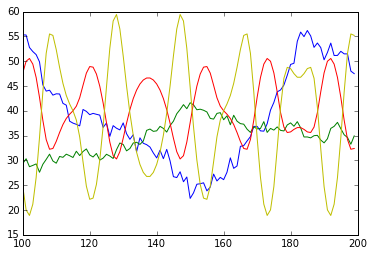

In [287]:
s = 100
do = 200
q = cost_item
plt.plot(t[s:do], q[s:do, 0], 'b', t[s:do], q[s:do, 1], 'g')
q = part_item
plt.plot(t[s:do], 120*q[s:do, 0], 'r', t[s:do], 120*q[s:do, 1], 'y')

In [288]:
profit_item = np.diff(cost_item, axis=0)/cost_item[:-1, :]
cost_case = np.sum(num_item*cost_item, axis=-1)
profit_case = np.diff(cost_case)/cost_case[:-1]

if np.sum(cost_item == 0) != 0 or np.sum(np.isclose(profit_item[0,:], profit_item[1,:])) != 0:
    print("Bad experiment")

In [289]:
X = np.arange(100*10).reshape(100, 10)
y = np.arange(100)
a0 = (y/np.sum(X*X, axis=1))[:, np.newaxis]*X
a0[np.sum(X*X, axis=1) == 0, :] = 0
Q0 = X[:, np.newaxis, :]*X[:, :, np.newaxis]
b0 = np.zeros((100,)) # needed???

In [6]:
arr = np.arange(2*2*2).reshape(2, 2, 2)
diag_view = np.diagonal(arr, axis1=1, axis2=2)
arr[:,np.arange(2),np.arange(2)] = 0
arr

array([[[0, 1],
        [2, 0]],

       [[0, 5],
        [6, 0]]])

In [4]:
arr = np.arange(2*2*2).reshape(2, 2, 2)

'1.10.2'

In [32]:
tmp.transpose(0, 2, 1)

array([[[ 11.,   6.,   5.,  13.,   5.],
        [  0.,   6.,   2.,   0.,  13.],
        [  1.,   7.,   0.,   8.,   9.],
        [ 11.,   8.,   1.,  17.,  11.],
        [ 11.,   7.,  13.,  16.,   8.]],

       [[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]]])

In [24]:
test = np.random.randint(0,20,size=(5, 5))

In [25]:
arr.dot(test)

array([[  75,   62,   67,  105,  113],
       [ 275,  167,  192,  345,  388],
       [ 475,  272,  317,  585,  663],
       [ 675,  377,  442,  825,  938],
       [ 875,  482,  567, 1065, 1213]])

In [26]:
arr = np.arange(5*5).reshape(5, 5)
tmp = np.zeros((3,5,5))
tmp[0,:,:]=test
np.transpose(np.dot(arr, tmp), axes=(1, 0, 2))

array([[[   75.,    62.,    67.,   105.,   113.],
        [  275.,   167.,   192.,   345.,   388.],
        [  475.,   272.,   317.,   585.,   663.],
        [  675.,   377.,   442.,   825.,   938.],
        [  875.,   482.,   567.,  1065.,  1213.]],

       [[    0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.]],

       [[    0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     0.]]])

In [14]:
np.dot(arr.T, arr).dot(arr)

array([[45000, 49250, 53500, 57750, 62000],
       [48250, 52800, 57350, 61900, 66450],
       [51500, 56350, 61200, 66050, 70900],
       [54750, 59900, 65050, 70200, 75350],
       [58000, 63450, 68900, 74350, 79800]])

In [ ]:
np.invert()